# Modeling

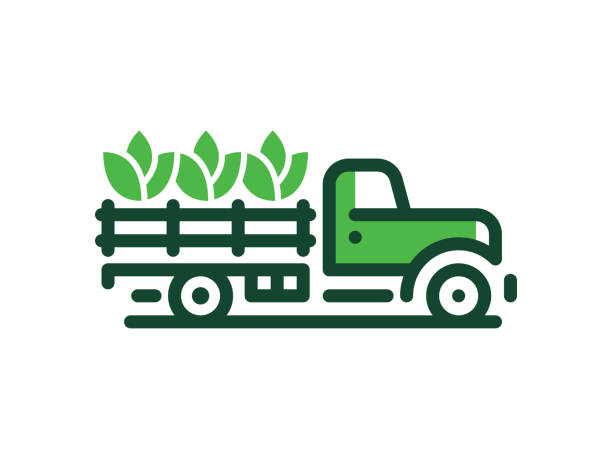

# Overview

The Instacart dataset contains historical order information, including product details, user behavior, and order characteristics. Our goal is to use a predictive model to analyze which features influence a customer's likelihood to reorder organic products. By examining the model's coefficients, we can gain insights into which features have the most significant impact on the prediction.

## Findings & Recommendations

By implementing these recommendations, GreenGrocer can enhance customer satisfaction, increase customer retention, and drive higher reorder rates, ultimately leading to improved business performance and growth.

1. **Promote Organic Produce:**
    - Customers who previously ordered organic products are approximately 1.33 times more likely to reorder organic products in their upcoming order.
    - Targeted marketing campaigns on organic products
    - Highlight the benefits of organic items to attract and retain customers

2. **Encourage Frequent Purchases:**
    - Implement Loyalty programs & Subscription options
    - Personalize recommendations based on purchase history/frequent purchases

3. **Leverage Basket Size:**
    - Implement strategies to encourage customers to add more items to carts
    - Bundle related products
    - Special deals for bulk purchases

4. **Enhance Product Placement:**
    - Products added later to the cart have a lower chance of being reordered. Explore ways to streamline the add-to-cart process and ensure that customers find what they need quickly
    - Optimize the user interface for easier shopping
    - Implement "quick add" or one-click reordering features

## Data Preperation

In [1]:
#imports
import pandas as pd
import numpy as np
import scipy
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in files
aisle = pd.read_csv('data/aisles.csv')
department = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')

In [ ]:
dataframes = ['aisle', 'department', 'orders', 'order_products_prior', 'products']

for df_name in dataframes:
    df = globals()[df_name]
    print(f"DataFrame: {df_name}")
    print("Number of rows:", len(df))
    display(df.head())
    print("Info:")
    display(df.info())
    print("Describe:")
    display(df.describe())
    print("=" * 40)

In [3]:
#capping the days since to 29 to avoid outliers
orders = orders.loc[orders['days_since_prior_order'] <= 29]

In [5]:
#creating a column of if a product is organic or not
products['organic'] = products['product_name'].str.lower().str.contains('organic').astype(int)

In [6]:
#creating an organic produce column
products['organic_produce'] = np.where((products['organic'] == 1) & (products['department_id'] == 4), 1, 0)

In [4]:
#merging files together
df = products.merge(order_products_prior,on='product_id', how='inner')
df = pd.merge(df, aisle, on='aisle_id', how='inner')
df = pd.merge(df, department, on='department_id', how='inner')
df = pd.merge(df, orders, on='order_id', how='inner')

In [7]:
#creating an organic dataframe and dropping unused and categorical columns for modeling
organic_mod= df.loc[df['organic'] == 1]
organic_mod = organic_mod.drop(['organic','product_name','aisle', 'department','eval_set'], axis=1)

## Feature Engineering

The features used to build our models are:

- Order_id
- Order_number
- Average_days_between_orders
- Basket_size
- Aisle
- Department
- Product
- User_id
- Order_hour_of_day
- Order_dow(day of week)
- Average Product Position in cart
- Average days since a product was ordered

In [8]:
#Adding column average days between a users orders using days_since_prior_order
organic_mod['avg_days_btn_orders'] = organic_mod.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
organic_mod['avg_days_btn_orders'] = organic_mod['avg_days_btn_orders'].replace(np.nan, 1)

In [9]:
#adding a column 'basket_size' for the number of products in each order
organic_mod['basket_size'] = organic_mod.groupby('order_id')['product_id'].transform('count')

In [10]:
#adding a column 'avg_prod_cart_position' for the average placement of a product in a user cart
organic_mod['avg_prod_position'] = organic_mod.groupby('product_id')['add_to_cart_order'].transform('mean')

In [11]:
#adding a column for the average days since a product was ordered
organic_mod['avg_days_since_last_order_product'] = organic_mod.groupby('product_id')['days_since_prior_order'].transform('mean')

Checking for any missing data before splitting the data

In [17]:
# Calculate the percentage of missing values in each column
missing_percentage = (organic_mod.isnull().sum() / len(organic_mod)) * 100
# Create a new DataFrame to store the missing percentage for each column
missing_data = pd.DataFrame({'Column': organic_mod.columns, 'MissingPercentage': missing_percentage})
# Print the missing percentage for each column
missing_data

,Column,MissingPercentage
product_id,product_id,0.0
aisle_id,aisle_id,0.0
department_id,department_id,0.0
order_id,order_id,0.0
add_to_cart_order,add_to_cart_order,0.0
reordered,reordered,0.0
user_id,user_id,0.0
order_number,order_number,0.0
order_dow,order_dow,0.0
order_hour_of_day,order_hour_of_day,0.0


There no missing values and all columns are numeric

In [13]:
#checking final features
organic_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8786162 entries, 10 to 27286351
Data columns (total 16 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   product_id                         int64  
 1   aisle_id                           int64  
 2   department_id                      int64  
 3   order_id                           int64  
 4   add_to_cart_order                  int64  
 5   reordered                          int64  
 6   user_id                            int64  
 7   order_number                       int64  
 8   order_dow                          int64  
 9   order_hour_of_day                  int64  
 10  days_since_prior_order             float64
 11  organic_produce                    int32  
 12  avg_days_btn_orders                float32
 13  basket_size                        int64  
 14  avg_prod_position                  float64
 15  avg_days_since_last_order_product  float64
dtypes: float32(1), f

** **
# Modeling

### Train Test Split

I am using reordered as my target variable and have 14 features

In [14]:
#checking class balance
organic_mod['reordered'].value_counts(normalize=True)

1    0.692927
0    0.307073
Name: reordered, dtype: float64

In [15]:
# Separate features and target
X = organic_mod.drop('reordered', axis=1) #features
y = organic_mod['reordered'] #target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

** **
## Decision Tree Classifier (Baseline)

In [16]:
#instantiate a DecisionTreeClassifier
tree_model_base = DecisionTreeClassifier(random_state=42)

#fit the model on the train data
tree_model_base.fit(X_train, y_train)

#make predictions
y_pred_base = tree_model_base.predict(X_test)
tree_train_pred_base = tree_model_base.predict(X_train)

print("Train F1-Score:", f1_score(y_train, tree_train_pred_base))
print("Test F1-Score:", f1_score(y_test, y_pred_base))

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_base))

Train F1-Score: 1.0
Test F1-Score: 0.758637608086451
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.48      0.47    539599
           1       0.76      0.75      0.76   1217634

    accuracy                           0.67   1757233
   macro avg       0.61      0.61      0.61   1757233
weighted avg       0.67      0.67      0.67   1757233



#### Model Interpretation

Overall, the baseline model seems to have good precision and recall for both classes, with class 1 having slightly higher scores. However, since the model's training F1-score is perfect, there is a strong possibility of overfitting, which i'll work on next

I will run another Decision Tree Classifier this time with a max depth of 7 to see if we can reduce the overfitting.

## Decision Tree Classifier

In [17]:
#instantiate a DecisionTreeClassifier with a max_depth of 7
tree_model = DecisionTreeClassifier(max_depth=7,random_state=42)

#fit the model on the train data
tree_model.fit(X_train, y_train)

#make predictions on test and train data
y_pred = tree_model.predict(X_test)
tree_train_pred = tree_model.predict(X_train)

print("Train F1-Score:", f1_score(y_train, tree_train_pred))
print("Test F1-Score:", f1_score(y_test, y_pred))

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Train F1-Score: 0.8286801563157747
Test F1-Score: 0.8284152293583541
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.39      0.48    539599
           1       0.77      0.90      0.83   1217634

    accuracy                           0.74   1757233
   macro avg       0.70      0.64      0.65   1757233
weighted avg       0.73      0.74      0.72   1757233



#### Model Interpretation

Next lets check the feature imporantance from the Decision Tree Classifier

In [23]:
feature_importances = tree_model.feature_importances_
feature_names = X_train.columns.tolist()

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance in descending order
sorted_features = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 7 features
top_features = sorted_features.head(5)

print("Top 10 Features:")
top_features

Top 10 Features:


,Feature,Importance
6,order_number,0.754493
14,avg_prod_position,0.180286
4,add_to_cart_order,0.034027
13,basket_size,0.014056
2,department_id,0.011968


## XGBoost Classifier

In [38]:
# Create a XGB model
final_model = xgb.XGBClassifier(max_depth=7, random_state=42)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)
train_pred = final_model.predict(X_train)

print("Train F1-Score:", f1_score(y_train, train_pred))
print("Test F1-Score:", f1_score(y_test, y_pred))

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

[15:58:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Train F1-Score: 0.8403275618786884
Test F1-Score: 0.8391936229302174
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.44      0.53    539599
           1       0.78      0.90      0.84   1217634

    accuracy                           0.76   1757233
   macro avg       0.73      0.67      0.68   1757233
weighted avg       0.75      0.76      0.74   1757233



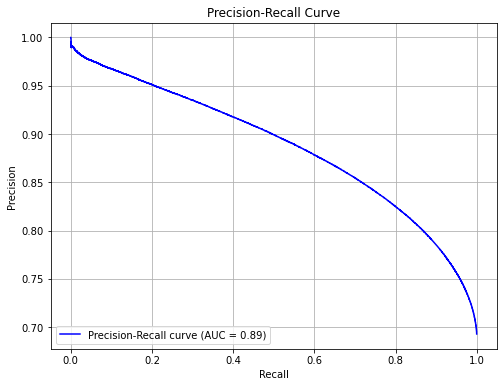

AUC-PR: 0.8869928617034892


In [39]:
from sklearn.metrics import precision_recall_curve, auc

# Make predictions
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Calculate AUC-PR
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall curve (AUC = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print("AUC-PR:", auc_pr)

The Dataset was highly imbalanced so to validate performance of the model to see how it was handling this. Looking at the Precision-Recall Curve, the AUC-PR score of 89% indicates that our XGB model is effective at identifying reorders by customers. It strikes a balance between correctly identifying reorders and avoiding misclassification.

### Feature Importance

In [ ]:
xgb.plot_importance(final_model)
plt.show()

In [40]:
# Get feature importances
importances = final_model.feature_importances_

# Get feature names
feature_names = X_train.columns.tolist()   # Replace with your actual feature names

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
6,order_number,0.430876
13,avg_prod_position,0.190187
4,add_to_cart_order,0.087392
2,department_id,0.063957
12,basket_size,0.050880
10,organic_produce,0.035253
14,avg_days_since_last_order_product,0.032885
1,aisle_id,0.032573
9,days_since_prior_order,0.030816
0,product_id,0.017432


Now I will take those top 7 features and run them through a logistic regression to get coefficents and odds ratios

In [41]:
# Select the top features from my xgb model
features = [
    'order_number',
    'avg_prod_position',
    'add_to_cart_order',
    'department_id',
    'basket_size',
    'organic_produce',
    'avg_days_since_last_order_product'
]

# Create a new DataFrame with only the selected features
X_train_xgb = X_train[features]
X_test_xgb = X_test[features]

# Instantiate the LogisticRegression model
logreg_model = LogisticRegression(penalty='none',random_state=42)

# Fit the model on the selected features
logreg_model.fit(X_train_xgb, y_train)

# Make predictions on train and test sets
logreg_lgb_train_pred = logreg_model.predict(X_train_xgb)
logreg_lgb_test_pred = logreg_model.predict(X_test_xgb)

print("Train F1-Score:", f1_score(y_train, logreg_xgb_train_pred))
print("Test F1-Score:", f1_score(y_test, logreg_xgb_test_pred))

# Display classification report
print("Classification Report:\n", classification_report(y_test, logreg_xgb_test_pred))

Train F1-Score: 0.8226141494304057
Test F1-Score: 0.8226179541943952
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.27      0.37    539599
           1       0.74      0.93      0.82   1217634

    accuracy                           0.72   1757233
   macro avg       0.68      0.60      0.60   1757233
weighted avg       0.70      0.72      0.68   1757233



In [42]:
# Geting the coefficients from the logistic Regression model
coefficients = logreg_model.coef_[0]

# Exponentiate the coefficients to interpret them as odds ratios
odds_ratios = np.exp(coefficients)

# Create a DataFrame to associate feature names with their coefficients and odds ratios
coefficients_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients, 'Odds Ratio': odds_ratios})

# Print the coefficients and odds ratios
coefficients_df.sort_values(by=['Coefficient', 'Odds Ratio'],ascending=False)

,Feature,Coefficient,Odds Ratio
5,organic_produce,0.287910,1.333637
6,avg_days_since_last_order_product,0.127655,1.136161
4,basket_size,0.071271,1.073872
0,order_number,0.039227,1.040006
3,department_id,0.009567,1.009613
2,add_to_cart_order,-0.057033,0.944563
1,avg_prod_position,-0.332809,0.716907
